In [1]:
%pdb on

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import tensorflow as tf
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
import time

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

# Train/Eval the model

In [4]:
def get_pipeline(model):
    alphabet = asr.text.Alphabet(lang='en')
    features_extractor = asr.features.MFCC(
        features_num=26,
        is_standardization=False,
        winlen=0.032,
        winstep=0.02,
    )
    optimizer = tf.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
    decoder = asr.decoder.GreedyDecoder()
    pipeline = asr.pipeline.CTCPipeline(
        alphabet, features_extractor, model, optimizer, decoder
    )
    callbacks = []
    return pipeline

In [5]:
dev_dataset = asr.dataset.Audio.from_csv('./data/libri_dev/data_64s.csv', batch_size=8, use_filesizes=True, relative_paths=False)

In [6]:
model = asr.model.load_mozilla_deepspeech('./data/mozilla_deepspeech.pb')

load graph
Instructions for updating:
Use tf.gfile.GFile.
['IteratorV2', 'IteratorGetNext', 'Shape', 'strided_slice/stack', 'strided_slice/stack_1', 'strided_slice/stack_2', 'strided_slice', 'Const', 'conv1d/ExpandDims/dim', 'conv1d/ExpandDims', 'conv1d/ExpandDims_1/dim', 'conv1d/ExpandDims_1', 'conv1d', 'conv1d/Squeeze', 'Reshape/shape/1', 'Reshape/shape/2', 'Reshape/shape/3', 'Reshape/shape', 'Reshape', 'transpose/perm', 'transpose', 'Reshape_1/shape', 'Reshape_1', 'layer_1/bias', 'layer_1/bias/read', 'layer_1/weights', 'layer_1/weights/read', 'MatMul', 'BiasAdd', 'Relu', 'Minimum/y', 'Minimum', 'StringFormat', 'PrintV2', 'Identity', 'layer_2/bias', 'layer_2/bias/read', 'layer_2/weights', 'layer_2/weights/read', 'MatMul_1', 'BiasAdd_1', 'Relu_1', 'Minimum_1/y', 'Minimum_1', 'layer_3/bias', 'layer_3/bias/read', 'layer_3/weights', 'layer_3/weights/read', 'MatMul_2', 'BiasAdd_2', 'Relu_2', 'Minimum_2/y', 'Minimum_2', 'Reshape_2/shape', 'Reshape_2', 'cudnn_lstm/rnn/multi_rnn_cell/cell_0/

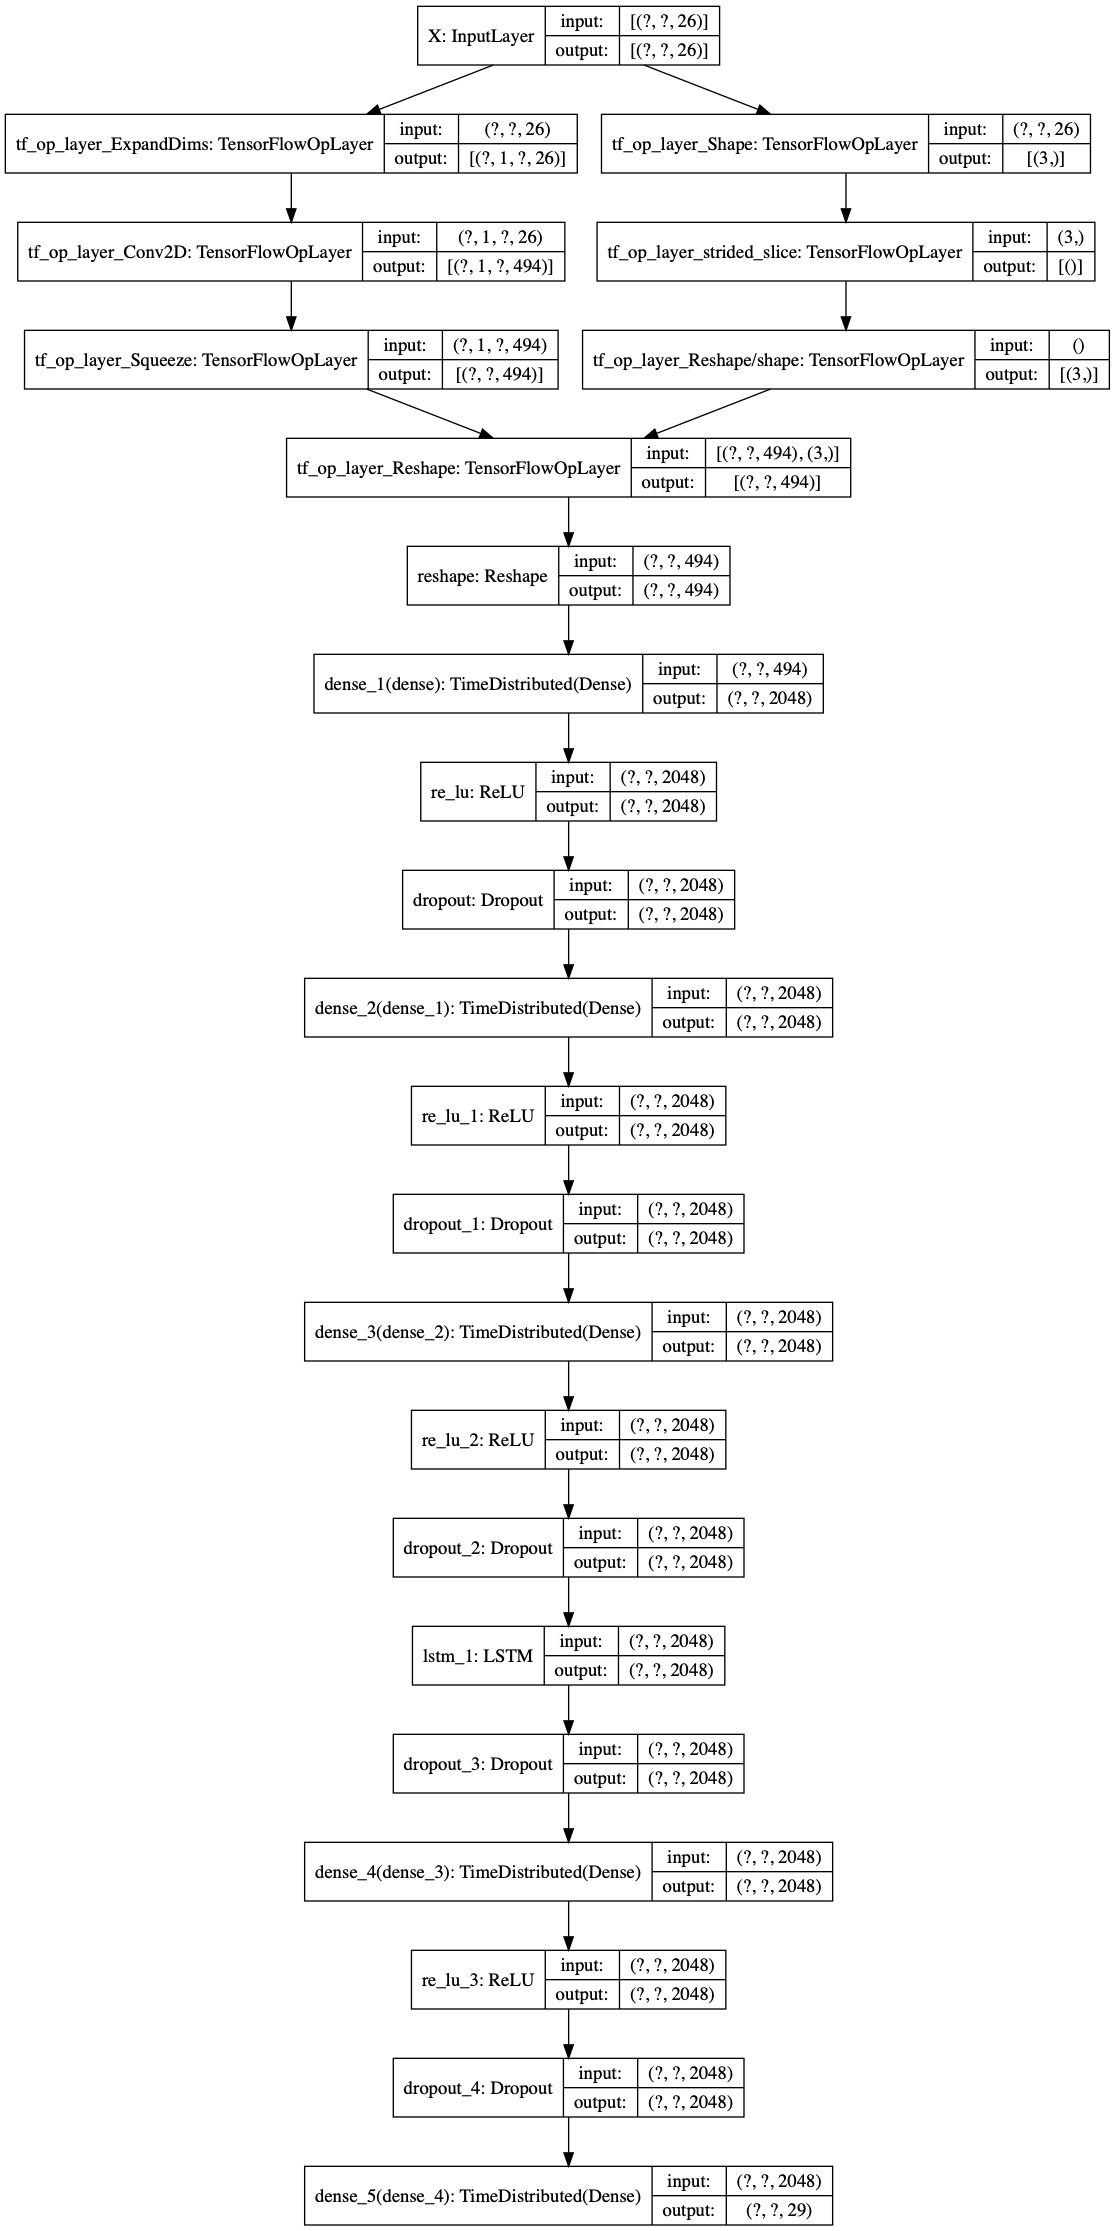

In [7]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [8]:
pipeline = get_pipeline(model)

In [9]:
start = time.time()
wer_ref, cer_ref = asr.evaluate.calculate_error_rates(pipeline, dev_dataset, print_pred=False)
elapsed_time = time.time() - start
print(f'WER: {wer}   CER: {cer}')
print(f'Elapsed time {elapsed_time}')

WER: 0.10459909061766165   CER: 0.03359192508939671
Elapsed time 84.02968406677246


# Speedup with TT decomposition

## Reference timings

In [16]:
from glob import glob
import json
from tflite_device_profile import (check_device, run_on_device, parse_profiler_output, batch_profile)
from tflite_device_profile import DEFAULT_PROF_CONFIG as config

In [17]:
from tt_dense_layer import TTDense
from tt_recurrent_layer import SimpleTTRNNCell, TTLSTMCell, FusedTTLSTMCell
custom_objects = {'TTDense': TTDense, 'SimpleTTRNNCell': SimpleTTRNNCell, 'TTLSTMCell': TTLSTMCell, 'FusedTTLSTMCell': FusedTTLSTMCell}

In [18]:
from transform_model import transform

In [19]:
# convert all saved models to TFLite
from h5_to_tflite import (export_model, batch_export)

In [10]:
model = asr.model.load_mozilla_deepspeech('./data/mozilla_deepspeech.pb', tflite_version=True)

load graph
Instructions for updating:
Use tf.gfile.GFile.
['IteratorV2', 'IteratorGetNext', 'Shape', 'strided_slice/stack', 'strided_slice/stack_1', 'strided_slice/stack_2', 'strided_slice', 'Const', 'conv1d/ExpandDims/dim', 'conv1d/ExpandDims', 'conv1d/ExpandDims_1/dim', 'conv1d/ExpandDims_1', 'conv1d', 'conv1d/Squeeze', 'Reshape/shape/1', 'Reshape/shape/2', 'Reshape/shape/3', 'Reshape/shape', 'Reshape', 'transpose/perm', 'transpose', 'Reshape_1/shape', 'Reshape_1', 'layer_1/bias', 'layer_1/bias/read', 'layer_1/weights', 'layer_1/weights/read', 'MatMul', 'BiasAdd', 'Relu', 'Minimum/y', 'Minimum', 'StringFormat', 'PrintV2', 'Identity', 'layer_2/bias', 'layer_2/bias/read', 'layer_2/weights', 'layer_2/weights/read', 'MatMul_1', 'BiasAdd_1', 'Relu_1', 'Minimum_1/y', 'Minimum_1', 'layer_3/bias', 'layer_3/bias/read', 'layer_3/weights', 'layer_3/weights/read', 'MatMul_2', 'BiasAdd_2', 'Relu_2', 'Minimum_2/y', 'Minimum_2', 'Reshape_2/shape', 'Reshape_2', 'cudnn_lstm/rnn/multi_rnn_cell/cell_0/

In [22]:
model.save('./models/ds.h5', save_format='h5')

In [23]:
# export dense model
export_model('./models/ds.h5', './tflite_models/ds.tflite', run_tests=True)

converting: ./models/ds.h5 => ./tflite_models/ds.tflite


In [ ]:
os.environ['ANDROID_ADB_SERVER_PORT'] = '5038'  # select which ADB to use. 5037 - local, 5038 - remote

In [ ]:
check_device(True, adb_cmd='adb-1.0.39')

In [27]:
# Turn off phone's gpu usage, it can't handle anything
config['use_gpu'] = False
config['num_threads'] = 4
config['enable_op_profiling'] = False
config['num_runs'] = 300
cpu_affinity = [0, 1, 2, 3]

In [28]:
# profile reference model
ref_res = run_on_device('./tflite_models/ds.tflite', prof_config=config, cpu_affinity=cpu_affinity)
ref_result = parse_profiler_output(ref_res, is_file=False)
ref_result

{'header': {'Min_num_runs': '300',
  'Min_runs_duration_(seconds)': '1',
  'Max_runs_duration_(seconds)': '300',
  'Inter-run_delay_(seconds)': '-1',
  'Num_threads': '4',
  'Benchmark_name': '',
  'Output_prefix': '',
  'Min_warmup_runs': '30',
  'Min_warmup_runs_duration_(seconds)': '0.5',
  'Graph': '/sdcard/asr_profiling/ds.tflite',
  'Input_layers': '',
  'Input_shapes': '',
  'Use_nnapi': '0',
  'nnapi_execution_preference': 'sustained_speed',
  'Use_legacy_nnapi': '0',
  'Use_gpu': '0',
  'Allow_lower_precision_in_gpu': '0',
  'Preferred_GL_object_type_in_gpu': '0',
  'Allow_fp16': '0',
  'Require_full_delegation': '0',
  'Enable_op_profiling': '0',
  'Max_profiling_buffer_entries': '1024'},
 'warmup': {'count': '30',
  'first': '277404',
  'curr': '168476',
  'min': '162423',
  'max': '277404',
  'avg': '185950',
  'std': '27447'},
 'main': {'count': '300',
  'first': '170985',
  'curr': '165508',
  'min': '156581',
  'max': '235698',
  'avg': '189390',
  'std': '26375'}}

In [29]:
ref_time = float(ref_result['main']['avg'])
ref_std = float(ref_result['main']['std'])

## TT timings

In [36]:
shape = ((16, 2, 2, 2, 16), (16, 2, 2, 2, 16))
tt_ranks = np.arange(2, 32, 1)

In [14]:
def get_tt_model(model, shape, dense_ranks, lstm_rank, lstm_r_rank):
    replacement_config = {
        'dense_2': {
            'config': {
                'name': 'tt_dense_2',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[0],
            },
            'init': {
                'max_tt_rank': dense_ranks[0],
                'epsilon': 0.0
            }
        },
       'dense_3': {
            'config': {
                'name': 'tt_dense_3',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[1],
            },
            'init': {
                'max_tt_rank': dense_ranks[1],
                'epsilon': 0.0
            }
        },
        'lstm': {
            'cell_type': 'FusedTTLSTMCell',
            'config': {
                'name': 'tt_fusedlstm_0',
                'input_dims': shape[0],
                'output_dims': shape[1],
            },
            'init': {
                'kernel': {
                    'max_tt_rank': lstm_rank,
                    'epsilon': 0.0
                },
                'recurrent': {
                    'max_tt_rank': lstm_r_rank,
                    'epsilon': 0.0
                }
            }
        },
        'dense_4': {
            'config': {
                'name': 'tt_dense0',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[2],
            },
            'init': {
                'max_tt_rank': dense_ranks[2],
                'epsilon': 0.0
            }
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=8)
    new_model.trainable = True
     
    return new_model

In [38]:
# build the models
for rank in tqdm(tt_ranks):
    tt_model = get_tt_model(model, shape, [rank, rank, rank], rank, rank)
    filename = f'./models/tt_ds_uniform_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

In [39]:
# transform to tflite
for rank in tqdm(tt_ranks): 
    in_filename = f'./models/tt_ds_uniform_r{rank}.h5'
    out_filename = f'./tflite_models/tt_ds_uniform_r{rank}.tflite'
    export_model(in_filename, out_filename, run_tests=True)

converting: ./models/tt_ds_uniform_r2.h5 => ./tflite_models/tt_ds_uniform_r2.tflite


converting: ./models/tt_ds_uniform_r3.h5 => ./tflite_models/tt_ds_uniform_r3.tflite


converting: ./models/tt_ds_uniform_r4.h5 => ./tflite_models/tt_ds_uniform_r4.tflite


converting: ./models/tt_ds_uniform_r5.h5 => ./tflite_models/tt_ds_uniform_r5.tflite


converting: ./models/tt_ds_uniform_r6.h5 => ./tflite_models/tt_ds_uniform_r6.tflite


converting: ./models/tt_ds_uniform_r7.h5 => ./tflite_models/tt_ds_uniform_r7.tflite


converting: ./models/tt_ds_uniform_r8.h5 => ./tflite_models/tt_ds_uniform_r8.tflite


converting: ./models/tt_ds_uniform_r9.h5 => ./tflite_models/tt_ds_uniform_r9.tflite


converting: ./models/tt_ds_uniform_r10.h5 => ./tflite_models/tt_ds_uniform_r10.tflite


converting: ./models/tt_ds_uniform_r11.h5 => ./tflite_models/tt_ds_uniform_r11.tflite


converting: ./models/tt_ds_uniform_r12.h5 => ./tflite_models/tt_ds_uniform_r12.tflite


converting: ./models/tt_ds_uniform_r13.h5 => ./tflite_models/tt_ds_uniform_r13.tflite


converting: ./models/tt_ds_uniform_r14.h5 => ./tflite_models/tt_ds_uniform_r14.tflite


converting: ./models/tt_ds_uniform_r15.h5 => ./tflite_models/tt_ds_uniform_r15.tflite


converting: ./models/tt_ds_uniform_r16.h5 => ./tflite_models/tt_ds_uniform_r16.tflite


converting: ./models/tt_ds_uniform_r17.h5 => ./tflite_models/tt_ds_uniform_r17.tflite


converting: ./models/tt_ds_uniform_r18.h5 => ./tflite_models/tt_ds_uniform_r18.tflite


converting: ./models/tt_ds_uniform_r19.h5 => ./tflite_models/tt_ds_uniform_r19.tflite


converting: ./models/tt_ds_uniform_r20.h5 => ./tflite_models/tt_ds_uniform_r20.tflite


converting: ./models/tt_ds_uniform_r21.h5 => ./tflite_models/tt_ds_uniform_r21.tflite


converting: ./models/tt_ds_uniform_r22.h5 => ./tflite_models/tt_ds_uniform_r22.tflite


converting: ./models/tt_ds_uniform_r23.h5 => ./tflite_models/tt_ds_uniform_r23.tflite


converting: ./models/tt_ds_uniform_r24.h5 => ./tflite_models/tt_ds_uniform_r24.tflite


converting: ./models/tt_ds_uniform_r25.h5 => ./tflite_models/tt_ds_uniform_r25.tflite


converting: ./models/tt_ds_uniform_r26.h5 => ./tflite_models/tt_ds_uniform_r26.tflite


converting: ./models/tt_ds_uniform_r27.h5 => ./tflite_models/tt_ds_uniform_r27.tflite


converting: ./models/tt_ds_uniform_r28.h5 => ./tflite_models/tt_ds_uniform_r28.tflite


converting: ./models/tt_ds_uniform_r29.h5 => ./tflite_models/tt_ds_uniform_r29.tflite


converting: ./models/tt_ds_uniform_r30.h5 => ./tflite_models/tt_ds_uniform_r30.tflite


converting: ./models/tt_ds_uniform_r31.h5 => ./tflite_models/tt_ds_uniform_r31.tflite


In [40]:
os.environ['ANDROID_ADB_SERVER_PORT'] = '5038'  # select which ADB to use. 5037 - local, 5038 - remote

In [41]:
check_device(True, adb_cmd='adb-1.0.39')

Found device: AEJ0117C11000167


True

In [42]:
# Turn off phone's gpu usage, it can't handle anything
config['use_gpu'] = False
config['num_threads'] = 4
config['enable_op_profiling'] = False
config['num_runs'] = 300
cpu_affinity = [0, 1, 2, 3]

In [43]:
# profile all models
for rank in tqdm(tt_ranks):
    res = run_on_device(f'./tflite_models/tt_ds_uniform_r{rank}.tflite',
                      prof_config=config, cpu_affinity=cpu_affinity)
    res_parsed = parse_profiler_output(res, is_file=False)
    json.dump(res_parsed, open(f'./profiling_output/tt_ds_uniform_r{rank}.json', 'w'))

In [46]:
def get_execution_times(results_path):
    filenames = glob(results_path + '*.json')
    
    results_by_rank = []
    for filename in filenames:
        basename = os.path.basename(filename).split('.')[0]
        rank = int(basename.split('_r')[1].split('_')[0])
        result = json.load(open(filename, 'r'))
        results_by_rank.append((rank, float(result['main']['avg']), float(result['main']['std'])))
    results_by_rank.sort(key = lambda x: x[0])
    
    ranks, times, stds = zip(*results_by_rank)
    return np.array(ranks), np.array(times), np.array(stds)

In [47]:
ranks, times, stds = get_execution_times('./profiling_output/tt_ds_uniform')

In [48]:
times

array([ 29967.9,  28832.3,  28321.6,  29763.4,  31253.5,  35595.2,
        38672.4,  43557.2,  45614.7,  50679.1,  54214.3,  61162.5,
        65965. ,  72137.9,  73553.2,  80471.5,  85299.4,  92929. ,
        97123.7, 105399. , 108830. , 116824. , 122328. , 134611. ,
       143091. , 153630. , 157329. , 167328. , 180468. , 192274. ])

Text(0.5, 0.98, 'Network execution time as function of rank')

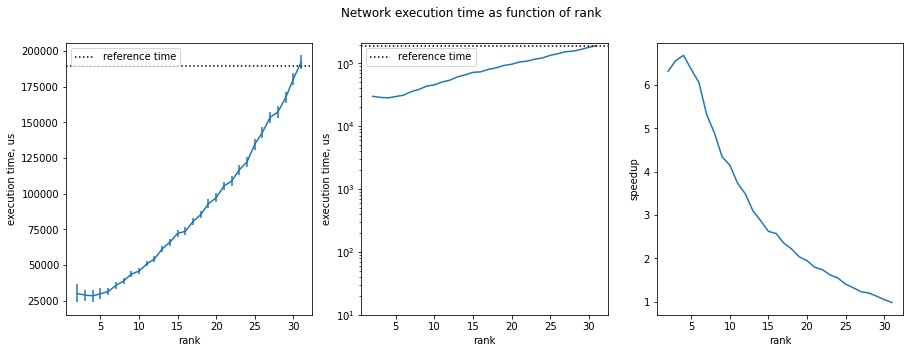

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].errorbar(ranks, times, stds)
axes[0].axhline(ref_time, ls=':', label='reference time', c='k')
axes[1].semilogy(ranks, times)
axes[1].axhline(ref_time, ls=':', label='reference time', c='k')
axes[2].plot(ranks, ref_time / times)

axes[0].set_xlabel('rank')
axes[0].set_ylabel('execution time, us')
axes[0].legend()
axes[1].set_ylim(10)
axes[1].set_xlabel('rank')
axes[1].set_ylabel('execution time, us')
axes[1].legend()
axes[2].set_xlabel('rank')
axes[2].set_ylabel('speedup')

fig.suptitle('Network execution time as function of rank')

array([ 5,  4,  3,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## Accuracy without tuning

In [10]:
tt_ranks = np.arange(2, 32, 1)
shape = ((16, 2, 2, 2, 16), (16, 2, 2, 2, 16))

In [11]:
dev_dataset = asr.dataset.Audio.from_csv('./data/libri_dev/data_64s.csv', batch_size=8, use_filesizes=True, relative_paths=False)

In [12]:
# build the models
model = asr.model.load_mozilla_deepspeech('./data/mozilla_deepspeech.pb', tflite_version=False)

load graph
['IteratorV2', 'IteratorGetNext', 'Shape', 'strided_slice/stack', 'strided_slice/stack_1', 'strided_slice/stack_2', 'strided_slice', 'Const', 'conv1d/ExpandDims/dim', 'conv1d/ExpandDims', 'conv1d/ExpandDims_1/dim', 'conv1d/ExpandDims_1', 'conv1d', 'conv1d/Squeeze', 'Reshape/shape/1', 'Reshape/shape/2', 'Reshape/shape/3', 'Reshape/shape', 'Reshape', 'transpose/perm', 'transpose', 'Reshape_1/shape', 'Reshape_1', 'layer_1/bias', 'layer_1/bias/read', 'layer_1/weights', 'layer_1/weights/read', 'MatMul', 'BiasAdd', 'Relu', 'Minimum/y', 'Minimum', 'StringFormat', 'PrintV2', 'Identity', 'layer_2/bias', 'layer_2/bias/read', 'layer_2/weights', 'layer_2/weights/read', 'MatMul_1', 'BiasAdd_1', 'Relu_1', 'Minimum_1/y', 'Minimum_1', 'layer_3/bias', 'layer_3/bias/read', 'layer_3/weights', 'layer_3/weights/read', 'MatMul_2', 'BiasAdd_2', 'Relu_2', 'Minimum_2/y', 'Minimum_2', 'Reshape_2/shape', 'Reshape_2', 'cudnn_lstm/rnn/multi_rnn_cell/cell_0/cudnn_compatible_lstm_cell/kernel', 'cudnn_lstm

In [20]:
for rank in tqdm(tt_ranks):
    tt_model = get_tt_model(model, shape, [rank, rank, rank], rank, rank)
    filename = f'./models/tt_ds_uniform_fix_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

In [25]:
def get_accuracy_by_rank_fixed(test_ds, models_filename_template, ranks):
    wers = []
    cers = []
    for rank in tqdm(ranks):
        model_filename = models_filename_template.format(rank)
        tt_model = tf.keras.models.load_model(model_filename, custom_objects=custom_objects)
        pipeline = get_pipeline(tt_model)
        wer, cer = asr.evaluate.calculate_error_rates(pipeline, test_ds, print_pred=False)
        wers.append(wer)
        cers.append(cer)
    return np.array(ranks), np.array(wers), np.array(cers)

In [26]:
ranks, wers_fix, cers_fix = get_accuracy_by_rank_fixed(dev_dataset, './models/tt_ds_uniform_fix_r{}.h5', tt_ranks)

KeyboardInterrupt: 

> /Users/roman/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/eager/execute.py(60)quick_execute()
     58     ctx.ensure_initialized()
     59     tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
---> 60                                         inputs, attrs, num_outputs)
     61   except core._NotOkStatusException as e:
     62     if name is not None:

ipdb> up
> /Users/roman/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/eager/function.py(598)call()
    596               inputs=args,
    597               attrs=attrs,
--> 598               ctx=ctx)
    599         else:
    600           outputs = execute.execute_with_cancellation(

ipdb> up
> /Users/roman/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/eager/function.py(1746)_call_flat()
   1744       # No tape is watching; skip to running the function.
   1745       return self._build_call_outputs(self._inference_function.call(
-> 1746           ctx, args

ipdb> up
> /Users/roman/Documents/projects/asr_speedup/src/Automatic-Speech-Recognition/automatic_speech_recognition/evaluate/evaluate.py(22)calculate_error_rates()
     20             predictions = pipeline.predict(data)
     21         else:
---> 22             predictions = pipeline.predict(batch_audio=data)
     23         if print_pred:
     24             print(predictions)

ipdb> up
> <ipython-input-25-c22035f43bff>(8)get_accuracy_by_rank_fixed()
      6         tt_model = tf.keras.models.load_model(model_filename, custom_objects=custom_objects)
      7         pipeline = get_pipeline(tt_model)
----> 8         wer, cer = asr.evaluate.calculate_error_rates(pipeline, test_ds, print_pred=False)
      9         wers.append(wer)
     10         cers.append(cer)

ipdb> up
> <ipython-input-26-b9fc0526ec5a>(1)<module>()
----> 1 ranks, wers_fix, cers_fix = get_accuracy_by_rank_fixed(dev_dataset, './models/tt_ds_uniform_fix_r{}.h5', tt_ranks)

ipdb> p wers
*** NameError: name 'wers' is no

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, ref_time / times, label='speedup')
ax2 = ax.twinx()
ax2.plot(r, wer_ref - wers_fix, ls='-', label='WER')
ax2.plot(r, cer_ref - cers_fix, ls=':', label='CER')
# r, acc_ref - acc_direct
ax.set_xlabel('rank')
ax.set_ylabel('speedup')
ax2.set_ylabel('accuracy drop')

fig.suptitle('Network execution time and accuracy as function of rank')